In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class RNNScratch(d2l.Module): 
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
        print(self.b_h.shape)

In [3]:
@d2l.add_to_class(RNNScratch)
def forward(self, inputs, state=None):
    if state is None:
        state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        # print("input[1] shape is ", inputs.shape[1])
    else:
        state, = state
    outputs = []
    # print("state = ", state, "\nits size is", state.shape)
    # count = 0
    for X in inputs:
        # count = count + 1
        # print(count)
        # print(X.shape)
        # print(self.W_xh.shape)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                        torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [4]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

torch.Size([32])


In [5]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

#### RNN based Natural Language Model

In [6]:
class RNNLMScratch(d2l.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_hq = nn.Parameter(torch.zeros(self.vocab_size))
    
    def training_steps(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [7]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [8]:
@d2l.add_to_class(RNNLMScratch)
def one_hot(self, X):
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    

In [9]:
@d2l.add_to_class(RNNLMScratch)
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_hq for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [10]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
print(outputs)
check_shape(outputs, (batch_size, num_steps, num_inputs))

tensor([[[-3.1588e-04, -4.3060e-04,  7.1218e-04,  ..., -6.4425e-04,
          -7.8385e-05,  3.8018e-04],
         [-2.9565e-04, -4.3231e-04,  7.1116e-04,  ..., -6.0038e-04,
          -5.7197e-05,  3.6832e-04],
         [-2.9418e-04, -4.3179e-04,  7.1105e-04,  ..., -5.9893e-04,
          -5.5661e-05,  3.6764e-04],
         ...,
         [-2.9419e-04, -4.3183e-04,  7.1106e-04,  ..., -5.9904e-04,
          -5.5585e-05,  3.6761e-04],
         [-2.9419e-04, -4.3183e-04,  7.1106e-04,  ..., -5.9904e-04,
          -5.5585e-05,  3.6761e-04],
         [-2.9419e-04, -4.3183e-04,  7.1106e-04,  ..., -5.9904e-04,
          -5.5585e-05,  3.6761e-04]],

        [[-3.1588e-04, -4.3060e-04,  7.1218e-04,  ..., -6.4425e-04,
          -7.8385e-05,  3.8018e-04],
         [-2.9565e-04, -4.3231e-04,  7.1116e-04,  ..., -6.0038e-04,
          -5.7197e-05,  3.6832e-04],
         [-2.9418e-04, -4.3179e-04,  7.1105e-04,  ..., -5.9893e-04,
          -5.5661e-05,  3.6764e-04],
         ...,
         [-2.9419e-04, -4

In [11]:
# gradient clipping
@d2l.add_to_class(d2l.Trainer)
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

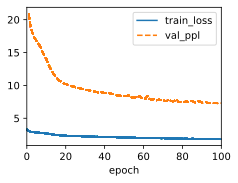

In [12]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

##### Decoding YAY

In [13]:
@d2l.add_to_class(RNNLMScratch)
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:
            outputs.append(vocab[prefix[i + 1]])
        else:
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis = 2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [14]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has four the the the th'